In [323]:
import ugradio
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq, fftshift, ifftshift
from scipy import signal as sig
from scipy.stats import norm

In [324]:
# Consistent Plot Params
titleSize = 13
axisSize = 13
graphSizeSingle = (8, 6)
graphSizeDouble = (15, 6)

In [325]:
# Data Extraction Helper Funcs
def extractRawData(folder, filename):
    prefix = "ugastro\\Lab2Data\\" + folder
    raw_data = np.load(prefix + filename)
    return raw_data

def getDataBlocks(data, num_blocks=None, window=None):
    if not window:
        window = len(data['time_data'][1])
    if not num_blocks:
        num_blocks = len(data['time_data']) - 1
    
    new_data = np.zeros((num_blocks, window), dtype=complex)
    for i, block in enumerate(data['time_data'][1:num_blocks+1]):
        real = block[:window, 0]
        imag = block[:window, 1]
        new_data[i] = normalize(real + (1j * imag))
        #new_data[i] = real + (1j * imag)
    return new_data

def getDataSingleBlock(data, block=1):
    real = data['time_data'][block][:, 0]
    imag = data['time_data'][block][:, 1]
    return normalize(real + (1j * imag))

def getSampleRate(data):
    return data['sample_rate']

def getGain(data):
    return data['gain']

def getUTC(data):
    return data['utc']

def getJulianDate(data):
    return data['jd']

def windowData(data):
    return data[:]

def normalize(data):
    return (data - np.mean(data)) #/ np.std(data)

def getTimes(N):
    return [i / 1e3 for i in range(0, N)]

times = [i / 1e3 for i in range(0, 1024)]

In [326]:
# Extracting Data

# 6.2.1
folder = "Section6_2\\6_2_1\\"
#data_rf_off_test = extractRawData(folder, "rf_off_test.npz")
#data_rf_on_test = extractRawData(folder, "rf_on_test.npz")


# 6.2.2
folder = "Section6_2\\6_2_2\\"
data_LSB = extractRawData(folder, "LSB_10000.npz")
data_USB = extractRawData(folder, "USB_10000.npz")


# 6.2.3
folder = "Section6_2\\6_2_3\\"
data_coldsky = extractRawData(folder, "Coldsky_10000.npz")
data_humans = extractRawData(folder, "Humanbody_10000.npz")


In [327]:
def graphOverlayTimeData(datasets, labels, signal, sample_rate=3.1e6, xlim=None):
    plt.figure(figsize=graphSizeSingle)
    times = getTimes(len(datasets[0]), sample_rate)

    for i, data in enumerate(datasets):
        plt.plot(times, data, label=labels[i])
        plt.scatter(times, data, s=10)

    plt.xlabel("Time (ms)", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylabel("Voltage Counts (Arbitrary Scale)", fontsize=axisSize)
    plt.title(f"{signal} Signals w/ 3.1 MHz Sample Rate", size=titleSize)
    plt.grid(True, alpha=0.3)
    plt.show()

In [328]:
def graphOverlayPowerSpectra(datasets, sample_rates, labels, signal, multiple=True, xlim=None):
    plt.figure(figsize=graphSizeSingle)
    mid = len(datasets[0]) // 2

    for i, data in enumerate(datasets):
        a = 1 if i == 0 else 0.1
        factor = 1
        c = "red" if i == 0 else "blue"
        fft_data = fft(data)
        fft_data_shifted = fftshift(fft_data)
        freq_bins = fftshift(fftfreq(len(data), d=1/sample_rates[i]))

        power_spectrum = 2 * (abs(fft_data_shifted) ** 2)
        print(len(power_spectrum))
        plt.plot(freq_bins / 1e3, power_spectrum / factor, label=f"{labels[i]}", alpha=1, color=c)

    plt.xlim(xlim)
    plt.xlabel("Frequency (kHz)", fontsize=axisSize)
    plt.ylabel("Power (Arbitary Scale)", fontsize=axisSize)
    plt.title(f"One Sided Power Spectra of {signal} Signals", size=titleSize)
    plt.legend()
    plt.grid(True)
    plt.show()

In [329]:
def graphAvgPowerSpectra(USB_blocks, LSB_blocks, sample_rate, center_freqs, xlim=None, ylim=None):
    plt.figure(figsize=graphSizeSingle)
    avg_power_USB = np.zeros(len(USB_blocks[0]))
    avg_power_LSB = np.zeros(len(USB_blocks[0]))

    for data in USB_blocks:
        fft_data = fft(data)
        fft_data_shifted = fftshift(fft_data)
        freq_bins = fftshift(fftfreq(len(data), d=1/sample_rate))

        avg_power_USB += (abs(fft_data_shifted) ** 2)
        
    for data in LSB_blocks:
        fft_data = fft(data)
        fft_data_shifted = fftshift(fft_data)
        freq_bins = fftshift(fftfreq(len(data), d=1/sample_rate))

        avg_power_LSB += (abs(fft_data_shifted) ** 2)
        
    avg_power_USB /= len(USB_blocks)
    avg_power_LSB /= len(LSB_blocks)

    factor = 150
    plt.plot(freq_bins / 1e3, (avg_power_USB - avg_power_LSB) / factor, label=f"USB (center freq {center_freqs[0]})", alpha=1)
    plt.plot(freq_bins / 1e3, (avg_power_LSB - avg_power_USB) / factor, label = f"LSB (center freq {center_freqs[1]})", alpha=1)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel("Frequency (kHz)", fontsize=axisSize)
    plt.ylabel("Power (Arbitary Scale)", fontsize=axisSize)
    plt.title(f"Power Spectra of USB and LSB ", size=titleSize)
    plt.legend()
    plt.grid(True)
    plt.show()

In [330]:
def graphAvgPowerSpectraLines(USB_blocks, LSB_blocks, sample_rate, xlim=None, ylim=None):
    fig, axs = plt.subplots(1, 2, figsize=graphSizeDouble)

    power_on = np.zeros((len(USB_blocks), len(USB_blocks[0])))
    power_off = np.zeros((len(USB_blocks), len(USB_blocks[0])))
    mid = len(USB_blocks[0]) // 2

    for i, data in enumerate(LSB_blocks):
        fft_data = fft(data)
        fft_data_shifted = fftshift(fft_data)
        freq_bins = fftshift(fftfreq(len(data), d=1/sample_rate))

        power_on[i][:mid] = (abs(fft_data_shifted) ** 2)[:mid]
        power_off[i][mid:] = (abs(fft_data_shifted) ** 2)[mid:]
        
    for j, data in enumerate(USB_blocks):
        fft_data = fft(data)
        fft_data_shifted = fftshift(fft_data)
        freq_bins = fftshift(fftfreq(len(data), d=1/sample_rate))

        power_on[j][mid:] = (abs(fft_data_shifted) ** 2)[mid:]
        power_off[j][:mid] = (abs(fft_data_shifted) ** 2)[:mid]

    avg_on_mean = np.mean(power_on, axis=0)
    avg_on_median = np.median(power_on, axis=0)
    avg_off_mean = np.mean(power_off, axis=0)
    avg_off_median = np.median(power_off, axis=0)  

    avg_on_mean[len(avg_on_mean)//2] = avg_on_mean[len(avg_on_mean)//2 - 1]
    avg_on_mean[len(avg_on_mean)//2 + 1] = avg_on_mean[len(avg_on_mean)//2 + 2]

    avg_off_mean[len(avg_off_mean)//2] = avg_off_mean[len(avg_off_mean)//2 - 1]
    avg_off_mean[len(avg_off_mean)//2 + 1] = avg_off_mean[len(avg_off_mean)//2 + 2]

    tau_line_mean = avg_on_mean / avg_off_mean
    tau_line_median = avg_on_median / avg_off_median

    factor = 150
    axs[0].plot(freq_bins / 1e3, avg_on_mean / factor, label="on-line w/ np.mean()", alpha=1)
    axs[1].plot(freq_bins / 1e3, avg_on_median / factor, label="on-line w/ np.median()", alpha=1)
    axs[0].plot(freq_bins / 1e3, avg_off_mean / factor, label="off-line w/ np.mean()", alpha=0.8)
    axs[1].plot(freq_bins / 1e3, avg_off_median / factor, label="off-line w/ np.median()", alpha=0.8)

    axs[0].set_xlim(xlim)
    axs[0].set_ylim(ylim)
    axs[1].set_xlim(xlim)
    axs[1].set_ylim(ylim)

    axs[0].set_xlabel("Frequency (kHz)", fontsize=axisSize)
    axs[1].set_xlabel("Frequency (kHz)", fontsize=axisSize)
    axs[0].set_ylabel("Power (Arbitary Scale)", fontsize=axisSize)
    axs[1].set_ylabel("Power (Arbitary Scale)", fontsize=axisSize)

    axs[0].set_title(f"On-/Off-line Power Spectra from USB and LSB ", size=titleSize)
    axs[1].set_title(f"On-/Off-line Power Spectra from USB and LSB ", size=titleSize)

    axs[0].legend()
    axs[1].legend()
    axs[0].grid(True)
    axs[1].grid(True)
    plt.show()

    return tau_line_mean, tau_line_median

def graphAvgPowerSpectraLinesSingle(USB_blocks, LSB_blocks, sample_rate, xlim=None, ylim=None):
    plt.figure(figsize=graphSizeSingle)

    power_on = np.zeros((len(USB_blocks), len(USB_blocks[0])))
    power_off = np.zeros((len(USB_blocks), len(USB_blocks[0])))
    mid = len(USB_blocks[0]) // 2

    for i, data in enumerate(LSB_blocks):
        fft_data = fft(data)
        fft_data_shifted = fftshift(fft_data)
        freq_bins = fftshift(fftfreq(len(data), d=1/sample_rate))

        power_on[i][:mid] = (abs(fft_data_shifted) ** 2)[:mid]
        power_off[i][mid:] = (abs(fft_data_shifted) ** 2)[mid:]
        
    for j, data in enumerate(USB_blocks):
        fft_data = fft(data)
        fft_data_shifted = fftshift(fft_data)
        freq_bins = fftshift(fftfreq(len(data), d=1/sample_rate))

        power_on[j][mid:] = (abs(fft_data_shifted) ** 2)[mid:]
        power_off[j][:mid] = (abs(fft_data_shifted) ** 2)[:mid]

    avg_on_mean = np.mean(power_on, axis=0)
    avg_on_median = np.median(power_on, axis=0)
    avg_off_mean = np.mean(power_off, axis=0)
    avg_off_median = np.median(power_off, axis=0)

    avg_on_mean[len(avg_on_mean)//2] = avg_on_mean[len(avg_on_mean)//2 - 1]
    avg_on_mean[len(avg_on_mean)//2 + 1] = avg_on_mean[len(avg_on_mean)//2 + 2]

    avg_off_mean[len(avg_off_mean)//2] = avg_off_mean[len(avg_off_mean)//2 - 1]
    avg_off_mean[len(avg_off_mean)//2 + 1] = avg_off_mean[len(avg_off_mean)//2 + 2]

    tau_line_mean = avg_on_mean / avg_off_mean
    tau_line_median = avg_on_median / avg_off_median
    factor = 150

    plt.plot(freq_bins / 1e6, avg_on_mean / factor, label="on-line", alpha=1)
    plt.plot(freq_bins / 1e6, avg_off_mean / factor, label="off-line", alpha=1)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel("Frequency (MHz)")
    plt.ylabel("Power (Arbitrary Scale)")
    plt.title(f"On-/Off-line Power Spectra versus IF Frequency ", size=titleSize)
    plt.legend()
    plt.grid()
    plt.show()

    return tau_line_mean, tau_line_median

In [331]:
def graphSingleGaussianHistogram(data, sample_rate, signals, num_bins):
    # Check block size first
    plt.figure(figsize=graphSizeSingle)

    bins = np.linspace(min(data), max(data), num_bins)
    plt.hist(data, bins=num_bins, density=True, alpha=1, label="Sampled Data")

    gaussian_fit = norm.pdf(bins, np.mean(data), np.std(data))
    plt.plot(bins, gaussian_fit, 'r--', linewidth=5, label="Gaussian Fit")

    plt.xlabel("Measured Voltage / Counts", fontsize=axisSize)
    plt.ylabel("Probability Density", fontsize=axisSize)
    plt.title(f"Noise of {signals} Signal w/ {sample_rate} & {num_bins} bins", size=titleSize)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [332]:
def graphTauLines(tau_mean, tau_median, sample_rate, xlim=None, ylim=None):
    plt.figure(figsize=graphSizeSingle)

    freq_bins = fftshift(fftfreq(len(tau_mean), d=1/sample_rate))

    plt.plot(freq_bins / 1e6, tau_mean, label=r"$\tau_{line}$ (mean)")
    plt.plot(freq_bins / 1e6, tau_median, label=r"$\tau_{line}$ (median)", alpha=0.7)

    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel("Frequency (MHz)", fontsize=axisSize)
    plt.ylabel("Ratio (Arbitary Scale)", fontsize=axisSize)
    plt.title(f"Line Shape of On-Line / Off-Line Ratio versus IF Frequency", size=titleSize)
    plt.legend()
    plt.grid(True)
    plt.show()

In [333]:
def computeCalibratedGain(coldsky, humans, T_cal=300):
    N = len(coldsky[0])
    
    avg_coldsky = np.mean(abs(fft(coldsky, axis=1) / N) ** 2, axis=0)
    avg_humans = np.mean(abs(fft(humans, axis=1) / N) ** 2, axis=0)

    avg_coldsky[len(avg_coldsky)//2] = avg_coldsky[len(avg_coldsky)//2 - 1]
    avg_coldsky[len(avg_coldsky)//2 + 1] = avg_coldsky[len(avg_coldsky)//2 + 2]

    avg_humans[len(avg_humans)//2] = avg_humans[len(avg_humans)//2 - 1]
    avg_humans[len(avg_humans)//2 + 1] = avg_humans[len(avg_humans)//2 + 2]

    bottom_sum = np.sum(avg_humans - avg_coldsky)
    coldsky_sum = np.sum(avg_coldsky)

    return (T_cal * coldsky_sum) / bottom_sum

In [334]:
def graphCalibratedT(T, xlim=None, ylim=None):
    plt.figure(figsize=graphSizeSingle)

    clipped_T = T[len(T)//2:]
    freq_bins = np.linspace(1420, 1421.5, len(clipped_T))
    plt.plot(freq_bins, clipped_T)

    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel("Frequency (MHz)", fontsize=axisSize)
    plt.ylabel("Temperature (K)", fontsize=axisSize)
    plt.title("Calibrated T Spectrum versus RF Frequency", size=titleSize)
    plt.grid()
    plt.show()

def graphCalibratedTDoppler(T, xlim=None, ylim=None):
    plt.figure(figsize=graphSizeSingle)
    c = 2.997e8

    clipped_T = T[len(T)//2:]
    freq_bins = np.linspace(1420, 1421.5, len(clipped_T))

    velocities = c * (-(freq_bins - 1420.405) / 1420.405)

    plt.plot(velocities / 1e3, clipped_T)

    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel("Doppler Velocity (km/s)", fontsize=axisSize)
    plt.ylabel("Temperature (K)", fontsize=axisSize)
    plt.title("Calibrated T Spectrum versus Doppler Velocity", size=titleSize)
    plt.grid()
    plt.show()

In [335]:
USB = getDataBlocks(data_USB)
LSB = getDataBlocks(data_LSB)
sample_rate = 3.1e6
center_freqs = ["1.420 GHz", "1.421 GHz"]

C:\Users\brand\AppData\Local\Temp\ipykernel_11556\2386819106.py:100: RuntimeWarning: invalid value encountered in divide
  tau_line_median = avg_on_median / avg_off_median


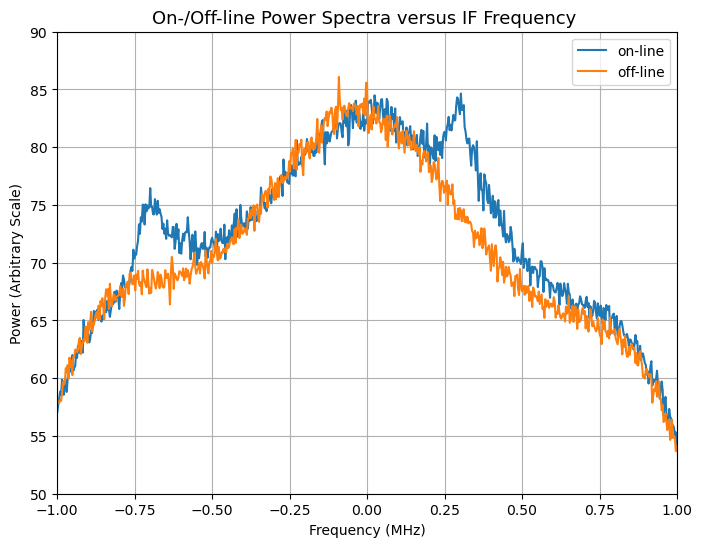

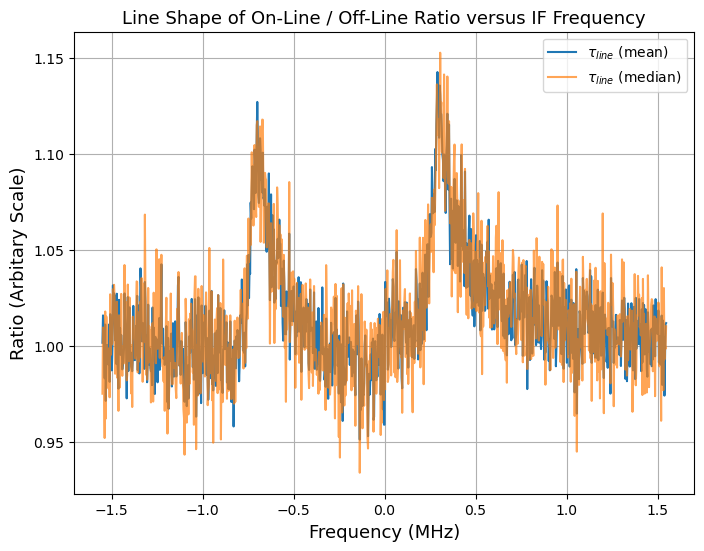

In [336]:
tau_mean, tau_median = graphAvgPowerSpectraLinesSingle(USB, LSB, sample_rate, xlim=(-1, 1), ylim=(50, 90))
graphTauLines(tau_mean, tau_median, sample_rate)

G = 127.366
Peak = 1420.285


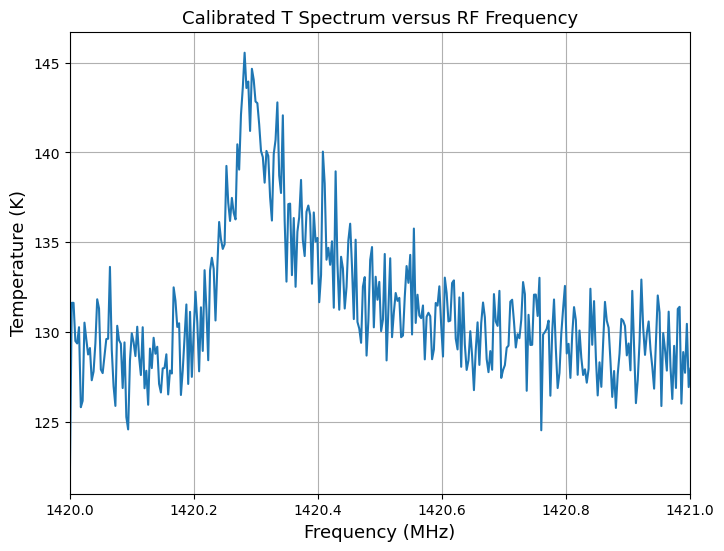

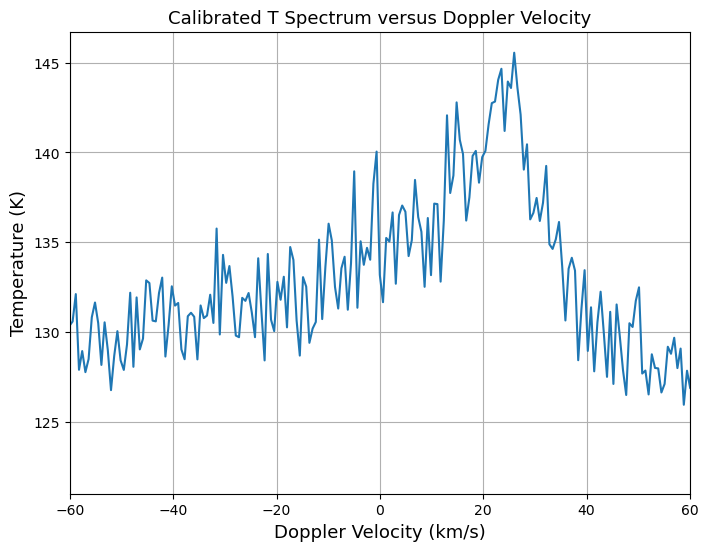

In [337]:
coldsky = getDataBlocks(data_coldsky)
humans = getDataBlocks(data_humans)

G = computeCalibratedGain(coldsky, humans, 300)
print(f"G = {round(G, 3)}")
T = tau_mean * G

clipped_T = T[len(T)//2:]
clipped_T.argmax()
print(f"Peak = {round(np.linspace(1420, 1421.5, len(clipped_T))[97], 3)}")

graphCalibratedT(T, xlim=(1420, 1421))
graphCalibratedTDoppler(T, xlim=(-60, 60))

In [ ]:
# Time Helper Functions
from astropy.time import Time
from astropy.coordinates import EarthLocation, AltAz, FK5, Galactic, ICRS, Angle
import astropy.units as units
from datetime import datetime

def formatTime(time_utc):
    return Time(datetime.strptime(str(time_utc), "%a %b %d %H:%M:%S %Y"), format="iso")

def horizontal_to_equitorial(az, alt, lat, lon, time_utc):
    location = EarthLocation(lat=lat*units.deg, lon=lon*units.deg)
    time_observed = formatTime(time_utc)
    coord = AltAz(az=az*units.deg, alt=alt*units.deg, obstime=time_observed, location=location)
    equitorial = coord.transform_to(ICRS())
    return equitorial.ra.deg, equitorial.dec.deg



In [363]:
t = getUTC(data_coldsky)
print(t)
print(str(t))


t = datetime.strptime(str(t), "%a %b %d %H:%M:%S %Y")
print(t)
print(Time(str(t), format="iso").mjd)
print(Time(str(t), format="iso").jd)


Thu Feb 13 00:04:40 2025
Thu Feb 13 00:04:40 2025
2025-02-13 00:04:40
60719.00324074074
2460719.503240741
